In [1]:
import os
import librosa
import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from laughter_classification import SSPNetDataSampler
from laughter_prediction import Predictor, FeatureExtractor, sample_by_frames

# Dataset

In [2]:
RATE = 16000
MODEL_PATH = 'model.h5'
CORPUS_PATH = 'vocalizationcorpus'
DATASET_PATH = 'dataset.csv.gz'

In [3]:
if os.path.exists(DATASET_PATH):
    print('Loading...')
    df = pd.read_csv(DATASET_PATH, compression='gzip')
else:
    sampler = SSPNetDataSampler(CORPUS_PATH)
    df = sampler.create_sampled_df(frame_sec=1)
    df = df.reset_index(drop=True)

In [4]:
df.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V15992,V15993,V15994,V15995,V15996,V15997,V15998,V15999,IS_LAUGHTER,SNAME
0,-295.0,-324.0,-469.0,-542.0,-369.0,-458.0,-769.0,-684.0,-303.0,-381.0,...,-249.0,-391.0,-871.0,-1891.0,-2621.0,-2441.0,-1950.0,-1294.0,0,S1584
1,-1865.0,-1519.0,2670.0,7234.0,8452.0,12315.0,16330.0,16887.0,17680.0,23076.0,...,14841.0,7036.0,-1370.0,-16575.0,-30324.0,-32768.0,-32555.0,-32767.0,0,S1584
2,9482.0,5240.0,1639.0,3002.0,6011.0,4404.0,1260.0,-918.0,-6017.0,-12629.0,...,32270.0,32073.0,32767.0,24000.0,-22656.0,-32767.0,-31964.0,-32768.0,0,S1584
3,51.0,812.0,-829.0,-3644.0,-6406.0,-7037.0,-5490.0,-3665.0,-2999.0,-3240.0,...,-110.0,-63.0,-355.0,-285.0,-113.0,18.0,-137.0,-190.0,0,S1584
4,-26.0,255.0,456.0,115.0,67.0,243.0,166.0,-84.0,319.0,86.0,...,4288.0,2943.0,2298.0,2011.0,1797.0,1794.0,1943.0,734.0,0,S1584


# Features

In [5]:
extractor = FeatureExtractor()
features = extractor.extract_features(df.iloc[:, :RATE].as_matrix(), RATE)
features['id'] = df.SNAME
features = features.set_index('id') 

In [6]:
target = pd.DataFrame({'id': df.SNAME.values, 'target': df.IS_LAUGHTER.values})
target = target.set_index('id')

In [7]:
features.head()

,FBANK1,FBANK2,FBANK3,FBANK4,FBANK5,FBANK6,FBANK7,FBANK8,FBANK9,FBANK10,...,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,MFCC11,MFCC12,MFCC13
id,,,,,,,,,,,,,,,,,,,,,
S1584,-19.146315,-28.408010,-32.275742,-29.140222,-31.922529,-33.822849,-31.385617,-20.917650,-5.993233,-2.859394,...,16.021065,-31.682884,-0.679488,-27.831694,-12.471103,-19.407312,1.703115,10.833529,-4.214706,-1.253909
S1584,-19.093442,-27.874032,-33.078090,-32.246639,-32.146322,-34.109597,-29.022695,-11.895732,-3.965927,-5.845816,...,13.300879,-41.993600,-12.109601,-36.206543,-4.334286,-25.023199,2.574899,10.067623,-7.016793,-10.236015
S1584,-18.496884,-23.579985,-25.924960,-27.148837,-27.077308,-25.285104,-21.242905,-11.804345,-11.576729,-8.389765,...,15.103401,-32.001664,-18.416174,-35.561710,-7.135464,-7.831687,-1.862122,0.500270,-7.430322,-4.998968
S1584,-21.587678,-28.500928,-33.008861,-31.792406,-34.397456,-34.634385,-33.402393,-32.179686,-31.450271,-29.748923,...,-1.656413,-27.003154,-16.895623,-27.502580,1.728151,-8.462211,6.196542,-3.152415,-11.927576,-4.929824
S1584,-18.382717,-28.298152,-32.741556,-34.614882,-36.046582,-39.645056,-39.165375,-34.300031,-32.609750,-25.607256,...,-13.387726,-24.788412,-15.905881,-14.593938,-9.154399,-3.825624,1.428975,0.631644,-3.826359,-3.811414


# Predictor

In [8]:
import keras

from keras.models import Model, load_model
from keras.layers import Input, Embedding, LSTM, Dense, Reshape, Dropout

/Users/rebryk/Projects/spbau/speech-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
class RNNPredictor(Predictor):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        
        mfcc_input = Input(shape=[14, 13], dtype='float32', name='MFCC_input')
        fbank_input = Input(shape=[14, 128], dtype='float32', name='FBANK_input')
        
        lstm_out = LSTM(32, return_sequences=True)(mfcc_input)
        auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

        layer = keras.layers.concatenate([lstm_out, fbank_input], axis=2)
        layer = Dense(32, activation='relu')(layer)
        layer = Dropout(0.5)(layer)
        layer = Dense(32, activation='relu')(layer)
        layer = Dropout(0.5)(layer)
        layer = Dense(32, activation='relu')(layer)
        output = Dense(1, activation='sigmoid', name='main_output')(layer)
        
        self.model = Model(inputs=[mfcc_input, fbank_input], outputs=[output, auxiliary_output])
        self.model.compile(optimizer='rmsprop', loss='binary_crossentropy', loss_weights=[1., 1.])
    
    def fit(self, X, y, epochs=50):
        X_mfcc, X_fbank = X[:, :, -13:], X[:, :, :128]
        self.model.fit([X_mfcc, X_fbank], [y, y], epochs=epochs, batch_size=self.batch_size)
    
    def predict(self, X):
        return np.array(self.predict_proba(X) > 0.5, dtype=int)
    
    def predict_proba(self, X):
        X_mfcc, X_fbank = X[:, :, -13:], X[:, :, :128]
        output, _ = self.model.predict([X_mfcc, X_fbank], batch_size=self.batch_size)
        return output.squeeze()
    
    def save_model(self, path):
        self.model.save(path)
        
    def load_model(self, path):
        self.model = load_model(path)

# Testing

In [10]:
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
def auc(y_true, y_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    return metrics.auc(fpr, tpr)

In [12]:
X = np.array([group.values for _, group in features.groupby('id')])
y = np.array([group.values for _, group in target.groupby('id')])

In [13]:
has_target = y.squeeze().sum(axis=1) > 0
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, val_index = list(sss.split(X, has_target))[0]

In [14]:
X_train, y_train = X[train_index], y[train_index]
X_val, y_val = X[val_index], y[val_index]

In [23]:
predictor = RNNPredictor()

if os.path.exists(MODEL_PATH):
    predictor.load_model(MODEL_PATH)
else:
    predictor.fit(X_train, y_train, epochs=50)
    predictor.save_model(MODEL_PATH)

Epoch 1/50
2188/2188 [==============================] - 2s 701us/step - loss: 0.9415 - main_output_loss: 0.5480 - aux_output_loss: 0.3934
Epoch 2/50
2188/2188 [==============================] - 1s 362us/step - loss: 0.3531 - main_output_loss: 0.1982 - aux_output_loss: 0.1550
Epoch 3/50
2188/2188 [==============================] - 1s 404us/step - loss: 0.3137 - main_output_loss: 0.1737 - aux_output_loss: 0.1400
Epoch 4/50
2188/2188 [==============================] - 1s 432us/step - loss: 0.2940 - main_output_loss: 0.1581 - aux_output_loss: 0.1359
Epoch 5/50
2188/2188 [==============================] - 1s 414us/step - loss: 0.2819 - main_output_loss: 0.1490 - aux_output_loss: 0.1328
Epoch 6/50
2188/2188 [==============================] - 1s 418us/step - loss: 0.2705 - main_output_loss: 0.1401 - aux_output_loss: 0.1304
Epoch 7/50
2188/2188 [==============================] - 1s 415us/step - loss: 0.2675 - main_output_loss: 0.1392 - aux_output_loss: 0.1283
Epoch 8/50
2188/2188 [============

In [24]:
y_pred = predictor.predict_proba(X_val)

In [25]:
print(f'AUC: {auc(y_val.reshape(-1), y_pred.reshape(-1)):0.3f}')

AUC: 0.875


### Example

In [26]:
audio, rate = librosa.load('vocalizationcorpus/data/S2099.wav')
frames = sample_by_frames(audio, rate, 3 * rate // 4)

In [27]:
IPython.display.Audio(data=audio, rate=rate)

In [28]:
prob = predictor.predict_proba(np.array([features.loc['S2099'].as_matrix()]))

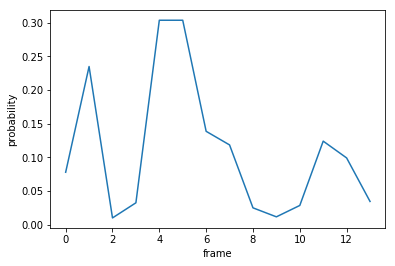

In [29]:
plt.ylabel('probability')
plt.xlabel('frame')
plt.plot(prob);

In [30]:
IPython.display.Audio(data=np.hstack((frames[4], frames[5])), rate=rate)